### 0. 환경설정

In [1]:
# 환경 설정
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.9 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 9.6 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595733 sha256=65cf11ad8ce22ce877c32a13d92da9da5aee9040bb0c6f23cedd60446406d14a
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 16.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pk

In [2]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-qqa92e42
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-qqa92e42
     |████████████████████████████████| 132 kB 26.2 MB/s 
     |████████████████████████████████| 4.5 MB 60.9 MB/s 
     |████████████████████████████████| 4.4 MB 66.4 MB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 
     |████████████████████████████████| 596 kB 75.3 MB/s 
     |████████████████████████████████| 6.6 MB 52.0 MB/s 
     |████████████████████████████████| 79 kB 10.4 MB/s 
     |████████████████████████████████| 8.9 MB 46.7 MB/s 
     |████████████████████████████████| 127 kB 64.5 MB/s 
  Created wheel for kobert: filename=kobert-0.2.3-py3-none-any.whl size=15674 sha256=c5669ab779b6e3f062df1eaba103b82969e8889de0af01d40c98b943bc3ab531
  Stored in directo

### 1. 모델링

In [3]:
# 라이브러리 호출
import pandas as pd
import torch
import gluonnlp as nlp
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm


#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

#GPU 사용 시
device = torch.device('cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# 감정분류 데이터셋
chatbot_data = pd.read_excel('/content/drive/MyDrive/CP1/Main/DB/한국어_단발성_대화_데이터셋.xlsx')

In [19]:
# 7개 감정 class 숫자에 대응
chatbot_data.loc[(chatbot_data['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [20]:
# 입력 데이터셋 토큰화
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [21]:
# 파라미터 세팅
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [22]:
# 훈련,테스트셋 분류
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.1, shuffle=True, random_state=42)

In [23]:
# model, tokenizer, vocab 설정
from kobert.utils import get_tokenizer

bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [24]:
# tokenization, int encoding, padding 진행
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok, vocab,  max_len, True, False)

In [25]:
# torch형식의 데이터셋 형성
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [26]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [27]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### 2. 모델 학습

In [28]:
# kobert 모델 학습
train_history=[]
test_history=[]
loss_history=[]
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
         
        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    #train_history.append(train_acc / (batch_id+1))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))

  0%|          | 0/543 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 1.9874176979064941 train acc 0.109375
epoch 1 batch id 201 loss 1.4621198177337646 train acc 0.2512437810945274
epoch 1 batch id 401 loss 1.1306923627853394 train acc 0.3654925187032419
epoch 1 train acc 0.4044584234126031


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 1 test acc 0.5086577868852459


  0%|          | 0/543 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.3241708278656006 train acc 0.5
epoch 2 batch id 201 loss 1.170505404472351 train acc 0.533193407960199
epoch 2 batch id 401 loss 1.0878275632858276 train acc 0.5647210099750624
epoch 2 train acc 0.5776683481463688


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 2 test acc 0.522233606557377


  0%|          | 0/543 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.2138681411743164 train acc 0.59375
epoch 3 batch id 201 loss 0.9028308987617493 train acc 0.6375155472636815
epoch 3 batch id 401 loss 0.7407548427581787 train acc 0.6651730049875312
epoch 3 train acc 0.6766779766194251


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 3 test acc 0.5488729508196721


  0%|          | 0/543 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.88287353515625 train acc 0.78125
epoch 4 batch id 201 loss 0.5953832268714905 train acc 0.7280006218905473
epoch 4 batch id 401 loss 0.5809962749481201 train acc 0.7524158354114713
epoch 4 train acc 0.7600851249099208


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 4 test acc 0.5545081967213116


  0%|          | 0/543 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.5729042887687683 train acc 0.8125
epoch 5 batch id 201 loss 0.443562775850296 train acc 0.7942319651741293
epoch 5 batch id 401 loss 0.4488815367221832 train acc 0.8087593516209476
epoch 5 train acc 0.8129616562575066


  0%|          | 0/61 [00:00<?, ?it/s]

epoch 5 test acc 0.553483606557377


### 3-1. 모델 저장 및 불러오기 (pickle)

In [ ]:
## pickle
import pickle

## Save pickle
with open('/content/drive/MyDrive/CP1/Main/Model/NLP_model2.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
## pickle
import pickle

## Load pickle
with open('/content/drive/MyDrive/CP1/Main/Model/NLP_model.pkl', 'rb') as f:
    model = pickle.load(f)

### 3-2.모델 저장 및 불러오기 (torch)

In [ ]:
## 저장
torch.save(model, '/content/drive/MyDrive/CP1/Main/Model/NLP_model2.pt')
torch.save(model.state_dict(), '/content/drive/MyDrive/CP1/Main/Model/NLP_model_state_dict2.pt')

In [ ]:
## 로드
#model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
model = torch.load('/content/drive/MyDrive/CP1/Main/Model/NLP_model.pt')
#model.load_state_dict(torch.load('/content/drive/MyDrive/CP1/Main/Model/NLP_model_state_dict.pt'))

### 4. 시각화

In [38]:
## 시각화
loss = pd.DataFrame({'loss': loss_history
            })
train_acc = pd.DataFrame({'train_acc': train_history
            })
test_acc = pd.DataFrame({'test_acc': test_history
            })

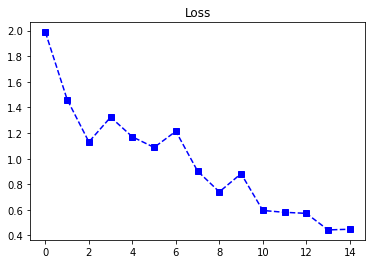

In [39]:
import matplotlib.pyplot as plt
train_acc = train_acc*100
test_acc = test_acc*100

plt.title('Loss')
plt.plot(loss,'bs--')
plt.show()

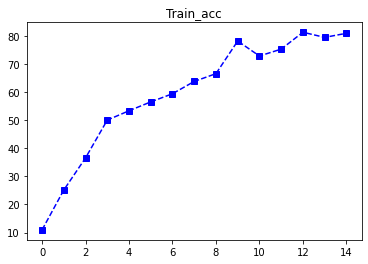

In [40]:
plt.title('Train_acc')
plt.plot(train_acc,'bs--')
plt.show()

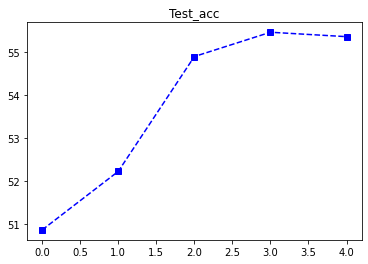

In [41]:
plt.title('Test_acc')
plt.plot(test_acc,'bs--')
plt.show()

### 5. MongoDB 데이터 불러오기

In [ ]:
from pymongo import MongoClient
client = MongoClient(host='3.37.202.252', port=27017)

DATABASE_NAME = 'youtube_comment_database'
COLLECTION_NAME = 'youtube_comment_collection'
database = client[DATABASE_NAME]
collection = database[COLLECTION_NAME]

In [ ]:
## 가져올 id 확인
post_id_as_str1 = str('62bcfb639dcd3b0ef430b7c6')   ## video_comments
post_id_as_str2 = str('62bcfb5c9dcd3b0ef430b7c5')   ## video_info

In [ ]:
## id 그대로 입력하면 None이 뜨므로 아래와 같이 bson처리후 불러옴
from bson.objectid import ObjectId
video_comments_bson_id = ObjectId(post_id_as_str1)
video_comments = collection.find_one({"_id": video_comments_bson_id})
video_info_bson_id = ObjectId(post_id_as_str2)
video_info = collection.find_one({"_id": video_info_bson_id})

In [ ]:
del video_comments['_id']
del video_info['_id']

In [ ]:
## video_comments 재구성
for movie_name in  video_info:
    video_comments[movie_name] = video_comments[movie_name]['Comments']

In [ ]:
def pad_dict_list(dict_list, padel=''):
    lmax = 0
    for lname in dict_list.keys():
        lmax = max(lmax, len(dict_list[lname]))
    for lname in dict_list.keys():
        ll = len(dict_list[lname])
        if  ll < lmax:
            dict_list[lname] += [padel] * (lmax - ll)
    return dict_list

video_comments = pad_dict_list(video_comments)
df = pd.DataFrame(video_comments)
df

,트랜스포머 3,히말라야,미션임파서블:고스트프로토콜,스파이더맨: 노 웨이 홈,트랜스포머: 패자의 역습,밀정,최종병기 활,겨울왕국,인터스텔라,보헤미안 랩소디,...,아이언맨 3,캡틴 아메리카: 시빌 워,해적: 바다로 간 산적,국가대표,디워,백두산,과속스캔들,스파이더맨: 파 프롬 홈,웰컴 투 동막골,공조
0,예고편 봤을때는 지렸는데 3부터 개망한 이유가 인간들도 신무기랍시고 총 몇 번 갈기...,이영화는 스틸컷만 봐도 눈물이 남,이제 내년이면 파이널 파트원 파트투로 나뉜다죠,7 9 4 1 58 1 58 부터 브금 소름돋는다,예고편 봤을때는 지렸는데 3부터 개망한 이유가 인간들도 신무기랍시고 총 몇 번 갈기...,,크 류승룡 님 연기가 일품이군요,와 8년전,영상 잘 봤습니다 최고 입니다 한국 최고조폭영화는 과연 무엇일까요 놀라실겁니다 몰입...,1시간만으로 재테크 할수있는게 파 다 사 워 리 이죠 유튜브 치면 나와여 20만원 벌어감,...,벌써 8년 전이네,이때 태어난 애들이 곧 초등학교 간다는게 제일 소름이다 체감상으론 고작 몇년전 같은...,솔까 해적2너무 기대했음 1편이 더 재밌고 연기도 손예진이 최고임,예고편으로도 재밌는 영화였지 물론 실제 영화도,지금와서 다시 만들면 안되나 킹콩 스파이더 맨 등등 다시 만들지않음 울나라 는 구리...,교육부 전국의 모든학생은 학교에 나오세요 국군이 보호하겠습니다,,그리고 지금은,,봤는데 볼만함
1,이 영화가 벌써 10년 전이라니,기다려 우리가 꼭 대리러 갈게,177 5 2 01 2 01,영화관에서 봤을때 개지렸는데 스파이더맨1에 나온 빌런들이 다 모여서 멀티버스 열리고...,이 영화가 벌써 10년 전이라니,,왜 배우이름이 안나오냐,와 7년전,안녕 7년 전 인간들아,파 다 사 워 리 직장인들 주시 비코로 지금 다 죽을라고하는데 나만 이거 알아서 살려줬네,...,이때 마블을 첨 봤었지,이때는 예고편에서 거의 다보여줬네,이게 영화가 벌써 7년이 훨씬 넘었다는 게 소름 돋는다,13년전 9월 같이 관람했던 여친이 생각나네요,진짜 예고편보고 가슴 벅찼는데 여의주란것도 신선하고 저 뱀도 미국 꼬마들이 저거 보...,예고편에 속은영화 스토리 처음부터끝까지 진부하고 말이안되는영화 배우진에 속았다 아맥...,,그땐 파 프롬 홈을 기다렸지만 지금은 노 웨이 홈을 기다린다 흥분 수치,,제가김주혁아저씨살려줄까요
2,이제는 10년전 영화,그럼 내려 가야지 거기서 삽니까,,11월 입대해서 12월에 훈련소 면회 미실시로 징집 훈련병들 대상으로 휴가 3박4일...,이제는 10년전 영화,,,와 자료로 물론 출처 남기고 쓰려고 들어 왔는데 갑자기 시즌1 예고편 보니까 웅장해진다,7년이 지나도 인터스텔라보는 나는 도대체,저 고딩인데 파 다 사 워 리 했으면 먹튀없이 돈 다주네,...,벌써 5년전이라는 댓글 보고 그렇게됐구나 했는데 3년전댓글이었네,이때 당시 마블코리아가 얼마나 일 안했는지를 보여주네 시빌위가 국내에서 4월27일에...,진짜 명품조연 어벤져스,,예고편만 기가 막히네,39,,노웨이홈 예고편나온줄,,공조2 화이팅 촬영 화이팅
3,이영화가 벌써 9년전이라니,이건 실화라서 더 크게 와닿았었지 크흑,,평행우주라는게 맞다는걸 증명하듯이 피터파커주변 사람들이 죽고 다른세계 피터파커처럼 ...,이영화가 벌써 9년전이라니,,,아 겨왕 사랑해 예고편만 봐도 뽕차네 개좋다,태훈이 존잘,나라에서는 해주는것도 없고 자영업자인데 해당도 안되는와중에 파 다 사 워 리 알고나...,...,6 90 1 42 1 42,이때 캡틴 싫어했었는데,손예진의 연기 스펙트럼은 어디까지인가,,코믹스러운거밖에 안보인다,내가 거기 있으면 정말 무서워요 거기 사는 분들이 정말 두려워서기도 만하면 용서를 ...,,7 1 1 27 1 27,,조작된도시 영화 임금님에사건수첩 영화보단 엄청재미없네욤
4,3편까지 예고편만 봐도 가슴이 웅장해졌는데,마지막 장면이 제일 슬펏 습니다 기다려 우리가 꼭 대리러 갈게,,이땐 몰랐지 스파이더맨이 어벤져스 시리즈의 마지막 희망이 될줄은,3편까지 예고편만 봐도 가슴이 웅장해졌는데,,,왜 자꾸 6년전 겨울왕국 영상을 계속 보여주는거,태훈이 천재 존경스러워,주변에서 다들 파 다 사 워 리 말하던데 그게 뭐죠 유튜브에 검색하면 나오나요,...,텐링즈 만다린 개봉기념 짭다린 한번 보러옴,0 0 2 18 2 18 그당시 예고편 나왔을때 사람들이 가장 열광했던 장면,,,진짜 예고편 보고 엄청 기대했었는데 가서 실망 엄청했었지,큰,,노 웨이 홈 예고편 보고 온 사람 손 들어,,현빈형님 사랑합니다
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,,,,,,,,,,,...,,,,,,,,그래서 가망없음이 번역할 예정입니까,,
1070,,,,,,,,,,,...,,,,,,,,친구들이 파커가 스파이더맨인거 알아요,,
1071,,,,,,,,,,,...,,,,,,,,아니 왜 저 물로 된 괴물이랑 저 초록이가 싸우는 장면이 왜 이리 샌드맨이랑 그린고...,,
1072,,,,,,,,,,,...,,,,,,,,스파이더맨 브금 웅장해질때 소름,,


### 6. 예측

In [ ]:
def predict(predict_sentence):
    if predict_sentence != '' :
        data = [predict_sentence, '0']
        dataset_another = [data]

        another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
        test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
        
        model.eval()

        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)

            valid_length= valid_length
            label = label.long().to(device)

            out = model(token_ids, valid_length, segment_ids)


            test_eval=[]
            for i in out:
                logits=i
                logits = logits.detach().cpu().numpy()

                if np.argmax(logits) == 0:
                    test_eval.append("공포")
                elif np.argmax(logits) == 1:
                    test_eval.append("놀람")
                elif np.argmax(logits) == 2:
                    test_eval.append("분노")
                elif np.argmax(logits) == 3:
                    test_eval.append("슬픔")
                elif np.argmax(logits) == 4:
                    test_eval.append("중립")
                elif np.argmax(logits) == 5:
                    test_eval.append("행복")
                elif np.argmax(logits) == 6:
                    test_eval.append("혐오")

        return test_eval[0]

In [ ]:
# 유튜브 댓글 데이터셋
def emotion(list_name):
    df_temp = df.copy()
    cnt = 1
    for movie_name in video_info:
        print(cnt)
        df_temp[movie_name+' emotion'] = df_temp[movie_name].apply(predict)
        cnt += 1
    return df_temp

df_temp = emotion(df)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
df_temp

,트랜스포머 3,히말라야,미션임파서블:고스트프로토콜,스파이더맨: 노 웨이 홈,트랜스포머: 패자의 역습,밀정,최종병기 활,겨울왕국,인터스텔라,보헤미안 랩소디,...,아이언맨 3emotion,캡틴 아메리카: 시빌 워emotion,해적: 바다로 간 산적emotion,국가대표emotion,디워emotion,백두산emotion,과속스캔들emotion,스파이더맨: 파 프롬 홈emotion,웰컴 투 동막골emotion,공조emotion
0,예고편 봤을때는 지렸는데 3부터 개망한 이유가 인간들도 신무기랍시고 총 몇 번 갈기...,이영화는 스틸컷만 봐도 눈물이 남,이제 내년이면 파이널 파트원 파트투로 나뉜다죠,7 9 4 1 58 1 58 부터 브금 소름돋는다,예고편 봤을때는 지렸는데 3부터 개망한 이유가 인간들도 신무기랍시고 총 몇 번 갈기...,,크 류승룡 님 연기가 일품이군요,와 8년전,영상 잘 봤습니다 최고 입니다 한국 최고조폭영화는 과연 무엇일까요 놀라실겁니다 몰입...,1시간만으로 재테크 할수있는게 파 다 사 워 리 이죠 유튜브 치면 나와여 20만원 벌어감,...,놀람,놀람,행복,행복,중립,중립,None,슬픔,None,행복
1,이 영화가 벌써 10년 전이라니,기다려 우리가 꼭 대리러 갈게,177 5 2 01 2 01,영화관에서 봤을때 개지렸는데 스파이더맨1에 나온 빌런들이 다 모여서 멀티버스 열리고...,이 영화가 벌써 10년 전이라니,,왜 배우이름이 안나오냐,와 7년전,안녕 7년 전 인간들아,파 다 사 워 리 직장인들 주시 비코로 지금 다 죽을라고하는데 나만 이거 알아서 살려줬네,...,중립,행복,놀람,중립,놀람,혐오,None,행복,None,공포
2,이제는 10년전 영화,그럼 내려 가야지 거기서 삽니까,,11월 입대해서 12월에 훈련소 면회 미실시로 징집 훈련병들 대상으로 휴가 3박4일...,이제는 10년전 영화,,,와 자료로 물론 출처 남기고 쓰려고 들어 왔는데 갑자기 시즌1 예고편 보니까 웅장해진다,7년이 지나도 인터스텔라보는 나는 도대체,저 고딩인데 파 다 사 워 리 했으면 먹튀없이 돈 다주네,...,놀람,혐오,행복,None,놀람,놀람,None,놀람,None,행복
3,이영화가 벌써 9년전이라니,이건 실화라서 더 크게 와닿았었지 크흑,,평행우주라는게 맞다는걸 증명하듯이 피터파커주변 사람들이 죽고 다른세계 피터파커처럼 ...,이영화가 벌써 9년전이라니,,,아 겨왕 사랑해 예고편만 봐도 뽕차네 개좋다,태훈이 존잘,나라에서는 해주는것도 없고 자영업자인데 해당도 안되는와중에 파 다 사 워 리 알고나...,...,놀람,중립,중립,None,중립,공포,None,놀람,None,혐오
4,3편까지 예고편만 봐도 가슴이 웅장해졌는데,마지막 장면이 제일 슬펏 습니다 기다려 우리가 꼭 대리러 갈게,,이땐 몰랐지 스파이더맨이 어벤져스 시리즈의 마지막 희망이 될줄은,3편까지 예고편만 봐도 가슴이 웅장해졌는데,,,왜 자꾸 6년전 겨울왕국 영상을 계속 보여주는거,태훈이 천재 존경스러워,주변에서 다들 파 다 사 워 리 말하던데 그게 뭐죠 유튜브에 검색하면 나오나요,...,행복,중립,None,None,슬픔,놀람,None,중립,None,행복
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1069,,,,,,,,,,,...,None,None,None,None,None,None,None,중립,None,None
1070,,,,,,,,,,,...,None,None,None,None,None,None,None,중립,None,None
1071,,,,,,,,,,,...,None,None,None,None,None,None,None,중립,None,None
1072,,,,,,,,,,,...,None,None,None,None,None,None,None,놀람,None,None


In [ ]:
df_temp = df_temp[['검사외전', '검사외전 emotion', '겨울왕국', '겨울왕국 emotion', '공조', '공조 emotion', '과속스캔들', '과속스캔들 emotion',
                   '관상', '관상 emotion', '국가대표', '국가대표 emotion', '디워', '디워 emotion', '미션임파서블:고스트프로토콜', '미션임파서블:고스트프로토콜 emotion',
                   '밀정', '밀정 emotion', '백두산', '백두산 emotion', '보헤미안 랩소디', '보헤미안 랩소디 emotion', '설국열차', '설국열차 emotion',
                   '스파이더맨: 노 웨이 홈', '스파이더맨: 노 웨이 홈 emotion', '스파이더맨: 파 프롬 홈', '스파이더맨: 파 프롬 홈 emotion',
                   '아이언맨 3', '아이언맨 3 emotion', '엑시트', '엑시트 emotion', '웰컴 투 동막골', '웰컴 투 동막골 emotion', '인터스텔라', '인터스텔라 emotion',
                   '최종병기 활', '최종병기 활 emotion', '캡틴 아메리카: 시빌 워', '캡틴 아메리카: 시빌 워 emotion', '트랜스포머 3', '트랜스포머 3 emotion', 
                   '트랜스포머: 패자의 역습', '트랜스포머: 패자의 역습 emotion', '해적: 바다로 간 산적', '해적: 바다로 간 산적 emotion', '히말라야', '히말라야 emotion']]

In [ ]:
df_temp.columns

Index(['검사외전', '검사외전 emotion', '겨울왕국', '겨울왕국 emotion', '공조', '공조 emotion',
       '과속스캔들', '과속스캔들 emotion', '관상', '관상 emotion', '국가대표', '국가대표 emotion',
       '디워', '디워 emotion', '미션임파서블:고스트프로토콜', '미션임파서블:고스트프로토콜 emotion', '밀정',
       '밀정 emotion', '백두산', '백두산 emotion', '보헤미안 랩소디', '보헤미안 랩소디 emotion',
       '설국열차', '설국열차 emotion', '스파이더맨: 노 웨이 홈', '스파이더맨: 노 웨이 홈 emotion',
       '스파이더맨: 파 프롬 홈', '스파이더맨: 파 프롬 홈 emotion', '아이언맨 3', '아이언맨 3 emotion',
       '엑시트', '엑시트 emotion', '웰컴 투 동막골', '웰컴 투 동막골 emotion', '인터스텔라',
       '인터스텔라 emotion', '최종병기 활', '최종병기 활 emotion', '캡틴 아메리카: 시빌 워',
       '캡틴 아메리카: 시빌 워 emotion', '트랜스포머 3', '트랜스포머 3 emotion', '트랜스포머: 패자의 역습',
       '트랜스포머: 패자의 역습 emotion', '해적: 바다로 간 산적', '해적: 바다로 간 산적 emotion', '히말라야',
       '히말라야 emotion'],
      dtype='object')

In [ ]:
df_temp.to_csv('video_comments_26-50_emotion.csv', index=False, encoding="utf-8-sig")